# Verificação de Aprendizagem - Machine Learning

## Experimentos

### Carregando os Dados

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

In [ ]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = w.strip().lower()

    # creating a space between a word and the punctuation following it eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping
    # -punctuation
    w = re.sub(r"([?.!,¿#@0-9])", r"", w)

    return w

In [ ]:
corpora = pd.read_csv('indigenous_cls.csv')
corpora = corpora.dropna().reset_index()

classes = np.unique(corpora['LANG'].tolist())
classes

array(['Apalaí', 'Apinayé', 'Apurinã', 'Bakairi', 'Guajajara', 'Guarani',
       'Kadiwéu', 'Kagwahiva', 'Kaigáng', 'Kaiwá', 'Karajá', 'Kayabí',
       'Macushi', 'Maxakalí', 'Mundurukú', 'Nadëb', 'Nambikuára',
       'Parecis', 'Paumarí', 'Portuguese', 'Rikbaktsa', 'Sateré-Mawé',
       'Terena', 'Tukano', 'Urubu-Kaapor', 'Xavánte', 'kayapó'],
      dtype='<U12')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

In [ ]:
print("Número de instâncias: ", corpora.shape[0])
samples = corpora.sample(frac=0.005)
print("Número de instâncias selcionadas : ", samples.shape[0])

Número de instâncias:  162061
Número de instâncias selcionadas :  810


In [ ]:
X = samples['TEXT'].apply(preprocess_sentence).to_numpy()
y = samples['LANG'].to_numpy()

pd.DataFrame.from_dict(Counter(y), orient='index')

,0
Kayabí,29
Nambikuára,28
Paumarí,24
Sateré-Mawé,33
kayapó,38
Tukano,34
Nadëb,36
Xavánte,32
Terena,36
Macushi,31


In [ ]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
X_transformed = tfidf.fit_transform(X)

### Análise Usando TSNE

Em análise preliminar, pode-se ver na figura a disposição dos idiomas em uma projeção 2D. 
Foi utilizado *t-distributed Stochastic Neighbor Embedding* (TSNE) para a redução da dimensionalidade e uma visualização dos dados.
Essa é uma forma bastante popular para visualização de dados em alta-dimensionalidade.
Nessa técnica os objetos são distribuídos de tal forma que pares semelhantes tem uma alta probabilidade na distribuição.
O modelo é treinado para minimizar a divergência em Kullback-Leibler *van2014accelerating*.
Após a redução da dimensionalidade das originais 18095 para apenas duas,  os dados foram postos em uma escala entre 0 e 1.

In [ ]:

X_embedded = TSNE(n_components=2).fit_transform(X_transformed)    
X_embedded.shape

(810, 2)

### Normalizando 

Aqui os dados são colocados entre 0 e 1

### Visalização 

Em análise preliminar, pode-se ver na figura a disposição dos idiomas em uma projeção 2D. 
Foi utilizado (TSNE) para a redução da dimensionalidade e uma visualização dos dados.
Essa é uma forma bastante popular para visualização de dados em alta-dimensionalidade.
Nessa técnica os objetos são distribuídos de tal forma que pares semelhantes tem uma alta probabilidade na distribuição.
O modelo é treinado para minimizar a divergência em Kullback-Leibler *van2014accelerating*.
Após a redução da dimensionalidade das originais 18095 para apenas duas,  os dados foram postos em uma escala entre 0 e 1.

Text(0.5, 1.0, 'Visualização dos Dados')

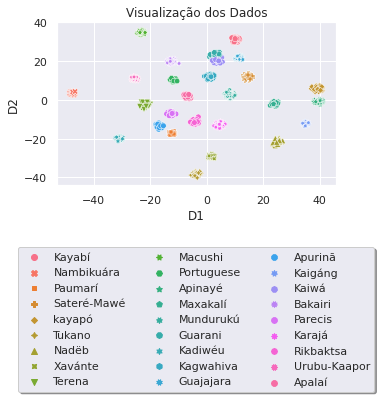

In [ ]:
import seaborn as sns

df = pd.DataFrame(X_embedded, columns=['D1', 'D2'])
df['Language'] = y
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(5.,3)})
g = sns.scatterplot(data=df, x="D1", y="D2", hue="Language", style="Language")
g.legend(loc='lower center', bbox_to_anchor=(0.5, -1.3),
          ncol=3, fancybox=True, shadow=True)
g.set_title("Visualização dos Dados")

### Preprocessando e Extraindo Features

In [ ]:
CLFS_LIST = [('LinearSVC',LinearSVC(max_iter=5000)), 
             ('MultinomialNB',MultinomialNB()),
             ('LogisticRegression',LogisticRegression())]

def run_experiment(X_, y_):
 
  exp_results = pd.DataFrame({'accuracy': [],'classifier_name':[],'fit_time':[]})
  cv = ShuffleSplit(n_splits=10, test_size=0.33, random_state=42)
  
  for clf in CLFS_LIST:
    step = 1
    clf_name, estimator = clf
    print(f"Treinando {clf_name}...")
    scores = cross_validate(estimator, X_, y_, cv=cv,
                            scoring=('accuracy', 'f1_macro'),
                            return_train_score=False)
    exp_df = pd.DataFrame({
        'accuracy':scores['test_accuracy'],
        'f1_macro':scores['test_f1_macro'],
        'classifier_name':[clf_name for _ in range(10)],
        'fit_time':scores['fit_time']+scores['score_time'],
        'dataset_name':['dataset'+str(i) for i in range(step, step+10)]
    })
    exp_results = exp_results.append(exp_df)
 
  return exp_results.fillna(0)

### Experimentos Usando TF-IDF

Na primeira série de experimentos realizados foram consideradas todo o vetor de características obtido através do pré-processamento usando TF-IDF.
Os dados são separados em 67\% para treinamento e 33\% para testes. O tempo médio é referente a média de tempo considerando o tempo de predição e treinamento somados em segundos.

In [ ]:
samples = corpora.sample(frac=0.01)
print("Número de instâncias selcionadas : ", samples.shape[0])

Número de instâncias selcionadas :  1621


In [ ]:
result_df = run_experiment(X_transformed, y)
result_df.to_csv('result_tf.csv')

Treinando LinearSVC...
Treinando MultinomialNB...
Treinando LogisticRegression...


In [ ]:
tfidf = TfidfVectorizer(analyzer='char', ngram_range=(2, 3))
X_transformed = tfidf.fit_transform(X)

In [ ]:
groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'accuracy':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open('result_acc.txt', 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
LinearSVC,0.999627,1.000000,0.001180,0.179092
LogisticRegression,0.998134,0.998134,0.001967,2.783454
MultinomialNB,0.995522,0.996269,0.003429,0.026137


In [ ]:
groups = result_df.groupby(['classifier_name'])
summary = groups.agg({'f1_macro':['mean', 'median', 'std'], 'fit_time':'mean'})
summary.columns = summary.columns.droplevel(0)
summary.columns = ['Média', 'Mediana', 'Desvio Padrão', 'Tempo Médio']

open('result_f1.txt', 'w').write(summary.to_latex())
summary

,Média,Mediana,Desvio Padrão,Tempo Médio
classifier_name,,,,
LinearSVC,0.999647,1.000000,0.001115,0.179092
LogisticRegression,0.997934,0.998313,0.002219,2.783454
MultinomialNB,0.994837,0.995537,0.003903,0.026137


### Experimentos Usando TSNE

In [ ]:
!git clone https://github.com/Tiagoblima/cd-diagram.git

fatal: destination path 'cd-diagram' already exists and is not an empty directory.


['LinearSVC' 'MultinomialNB' 'LogisticRegression']
LinearSVC             4.0
LogisticRegression    0.0
MultinomialNB         0.0
dtype: float64
MultinomialNB         2.65
LogisticRegression    1.95
LinearSVC             1.40
dtype: float64
('LinearSVC', 'MultinomialNB', 0.006714389785549478, True)
('LogisticRegression', 'MultinomialNB', 0.02743505651465022, False)
('LinearSVC', 'LogisticRegression', 0.04550026389635839, False)
Index(['MultinomialNB', 'LogisticRegression', 'LinearSVC'], dtype='object')
[1, 0]
[1, 2]
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


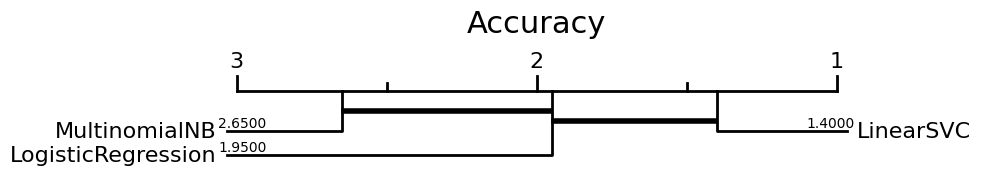

In [ ]:
from IPython.display import Image, display

!python cd-diagram/main.py --results result_tf.csv --metric accuracy --img cd-diagram1.png
display(Image('cd-diagram1.png'))

['LinearSVC' 'MultinomialNB' 'LogisticRegression']
LinearSVC             5.0
LogisticRegression    0.0
MultinomialNB         0.0
dtype: float64
MultinomialNB         2.70
LogisticRegression    1.95
LinearSVC             1.35
dtype: float64
('LinearSVC', 'MultinomialNB', 0.007640794824709983, True)
('LogisticRegression', 'MultinomialNB', 0.016924122629515245, True)
('LinearSVC', 'LogisticRegression', 0.027670427963096964, True)
Index(['MultinomialNB', 'LogisticRegression', 'LinearSVC'], dtype='object')
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


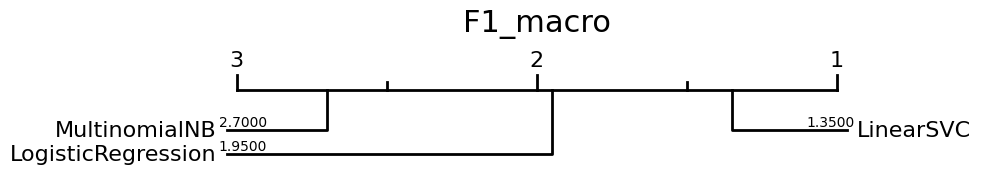

In [ ]:
from IPython.display import Image, display

!python cd-diagram/main.py --results result_tf.csv --metric f1_macro --img cd-f1_macro.png
display(Image('cd-f1_macro.png'))